In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
import preprocessing as pre
from models_analysis import plot_validation_curves, get_scores, get_scores_point
from xgboost import XGBClassifier

In [2]:
PATH_TO_DATA = 'user_identification_exps'

In [3]:
train_10users = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users_for_catch_me_ready.csv'), 
                            index_col=0)

In [4]:
train_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,is_top26,is_top27,is_top28,is_top29,is_top30,facebook_freq,binned_start_hour,unique_site_1,unique_site_2,facebook_flag
session_id,,,,,,,,,,,,,,,,,,,,,
1,192,574,133,3,133,133,3,133,203,133,...,False,False,False,False,False,0,"(6.984, 9.286]",0,0,1
2,415,193,674,254,133,31,393,3305,217,55,...,False,False,False,False,False,0,"(6.984, 9.286]",0,0,1
3,55,3,55,55,5,293,415,333,897,55,...,False,False,False,False,False,1,"(6.984, 9.286]",0,0,1
4,473,3306,473,55,55,55,55,937,199,123,...,False,False,False,False,False,0,"(6.984, 9.286]",0,0,1
5,342,55,5,3307,258,211,3308,2086,675,2086,...,False,False,False,False,False,1,"(6.984, 9.286]",0,0,1


In [5]:
train_10users.columns

Index(['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8',
       'site9', 'site10', 'diff_time1', 'diff_time2', 'diff_time3',
       'diff_time4', 'diff_time5', 'diff_time6', 'diff_time7', 'diff_time8',
       'diff_time9', 'diff_time10', 'start_hour', 'day_of_week', 'year',
       'month', 'day', 'time_of_day', 'user_id', 'session_timespan',
       'unique_sites', 'top_sites_time', 'is_top1', 'is_top2', 'is_top3',
       'is_top4', 'is_top5', 'is_top6', 'is_top7', 'is_top8', 'is_top9',
       'is_top10', 'is_top11', 'is_top12', 'is_top13', 'is_top14', 'is_top15',
       'is_top16', 'is_top17', 'is_top18', 'is_top19', 'is_top20', 'is_top21',
       'is_top22', 'is_top23', 'is_top24', 'is_top25', 'is_top26', 'is_top27',
       'is_top28', 'is_top29', 'is_top30', 'facebook_freq',
       'binned_start_hour', 'unique_site_1', 'unique_site_2', 'facebook_flag'],
      dtype='object')

In [6]:
bag_of_sites = ['site'+str(i) for i in range(1, 11)]
is_top_feats = ['is_top'+str(i) for i in range(1, 31)]
categorical_feats = ['binned_start_hour', 'day_of_week', 'day']
binary_feats = ['facebook_flag', 'unique_site_1', 'unique_site_2']
numerical_feats = ['unique_sites', 'facebook_freq']

num_preprocessor = FeatureUnion([
    ('woe_encoding', FunctionTransformer(lambda data: pre.woe_encoder(data, 'session_timespan', 
                                        max_lim=100, fill_method='outlier', for_pipeline=True))),
    ('others', FunctionTransformer(lambda data: data.loc[:, numerical_feats]\
                                   .drop('session_timespan',  axis=1)))
])

In [7]:
model = SGDClassifier(loss='log', n_jobs=-1)

In [41]:
pipeline = Pipeline(steps=[
    ('feature_processing', FeatureUnion(transformer_list=[
        ('binary_variables', FunctionTransformer(lambda data: data.loc[:, binary_feats])),
        ('categorical_variables', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, categorical_feats])),
            ('hot_encoding', OneHotEncoder(handle_unknown='ignore'))
            #('dim_reducing', TruncatedSVD(30))
        ])),
        ('bag_of_sites', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, bag_of_sites].apply(lambda row: \
                                                            ' '.join([str(x) for x in row]), axis=1))),
            ('vectorizer', TfidfVectorizer())
        ])),
        ('is_top_site', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, is_top_feats]))
            #('dim_reducing', TruncatedSVD(20))
        ])),
        ('numerical_variables', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, numerical_feats])),
         #   ('log_preprocessing', num_preprocessor),
            ('scaling', StandardScaler())
        ]))
    ])),
    ('classifier', model)
])

In [24]:
y_10users = train_10users.user_id
X_train, X_valid, y_train, y_valid = train_test_split(train_10users, y_10users, 
                                                      test_size=0.3)
data_params = [X_train, X_valid, y_train, y_valid]

### LogisticRegression

In [36]:
logit_params = {'classifier__alpha': np.logspace(-6, -3, 10)}

In [42]:
%%time
logit_searcher = GridSearchCV(pipeline, logit_params, scoring='accuracy', n_jobs=-1, 
                              return_train_score=True)
logit_searcher.fit(X_train, y_train)

Wall time: 6.59 s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x00000272D83E9700>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x00000272D83E90D0>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                                                         FunctionTransformer(fun

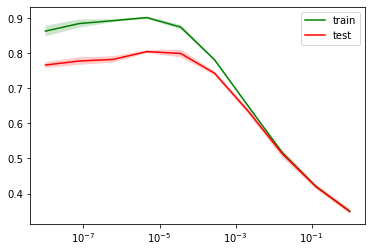

In [27]:
plt.xscale('log')
plot_validation_curves(logit_params['classifier__alpha'], logit_searcher.cv_results_)

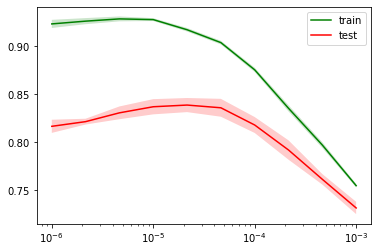

In [43]:
plt.xscale('log')
plot_validation_curves(logit_params['classifier__alpha'], logit_searcher.cv_results_)

In [44]:
scores_df = get_scores(logit_searcher, 'logit', *data_params, multi=True)

In [45]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
logit,0.839,0.839,0.81,0.982,0.834,0.796


### SVM

In [46]:
pipeline.set_params(classifier=SGDClassifier(n_jobs=-1))

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000272D83E9700>)),
                                                ('categorical_variables',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000272D83E90D0>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))])),
                                                ('bag_of_sites',...
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000272D83E9B80>)),
                                                                 ('vectorizer',
        

In [50]:
svm_params = {'classifier__alpha': np.logspace(-5, -3, 10)}

In [51]:
%%time
svm_searcher = GridSearchCV(pipeline, svm_params, scoring='accuracy', n_jobs=-1, 
                              return_train_score=True)
svm_searcher.fit(X_train, y_train)

Wall time: 5.02 s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x00000272D83E9700>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x00000272D83E90D0>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                                                         FunctionTransformer(fun

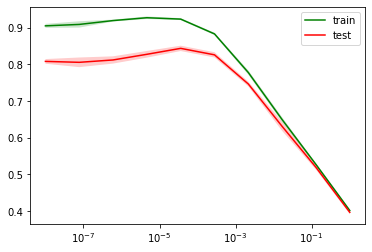

In [49]:
plt.xscale('log')
plot_validation_curves(svm_params['classifier__alpha'], svm_searcher.cv_results_)

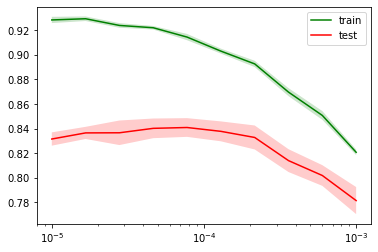

In [52]:
plt.xscale('log')
plot_validation_curves(svm_params['classifier__alpha'], svm_searcher.cv_results_)

In [53]:
scores_df = scores_df.append(get_scores(svm_searcher, 'svm', *data_params, multi=True, proba=False))

In [54]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
logit,0.839,0.839,0.81,0.982,0.834,0.796
svm,0.841,0.851,0.82,0.967,0.839,0.809


### XGBoost

In [55]:
pipeline.set_params(classifier=XGBClassifier(objective='multi:softmax', tree_method='gpu_hist', predictor='gpu_predictor',
                   use_label_encoder=False, verbosity=0))

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000272D83E9700>)),
                                                ('categorical_variables',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000272D83E90D0>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))])),
                                                ('bag_of_sites',...
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
             

In [56]:
xgb_params = {'classifier__n_estimators': 70,
             'classifier__max_depth': 7,
             'classifier__learning_rate': 0.4}
pipeline.set_params(**xgb_params)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000272D83E9700>)),
                                                ('categorical_variables',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000272D83E90D0>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))])),
                                                ('bag_of_sites',...
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=70,
                 

In [38]:
xgb_params = {'classifier__n_estimators': np.arange(1, 101, 10),
             'classifier__max_depth': [5]}

In [57]:
y = pd.concat((y_train, y_valid), axis=0)
y_xgb = LabelEncoder().fit_transform(y)
y_train_xgb = y_xgb[:y_train.shape[0]]
y_valid_xgb = y_xgb[y_train.shape[0]:]

In [58]:
data_params_xgb = [X_train, X_valid, y_train_xgb, y_valid_xgb]

In [40]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

Wall time: 15min 9s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000022BAFF75A60>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000022BAFF75AF0>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      predictor='gpu_predictor',
                               

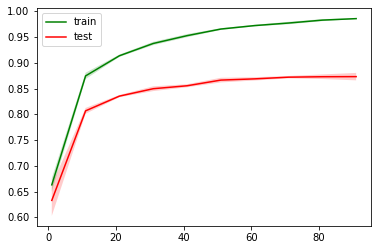

In [41]:
plot_validation_curves(xgb_params['classifier__n_estimators'], xgb_searcher.cv_results_)

In [42]:
xgb_params = {'classifier__n_estimators': [70],
             'classifier__max_depth': np.arange(1, 20, 2)}

In [43]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

Wall time: 1h 7min 57s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000022BAFF75A60>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000022BAFF75AF0>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      predictor='gpu_predictor',
                               

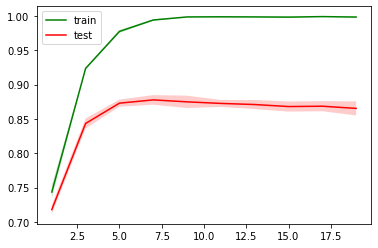

In [44]:
plot_validation_curves(xgb_params['classifier__max_depth'], xgb_searcher.cv_results_)

In [48]:
xgb_params = {'classifier__n_estimators': [70],
             'classifier__max_depth': [7],
             'classifier__learning_rate': np.linspace(0.1, 1., 10)}

In [49]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

Wall time: 39min 39s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000022BAFF75A60>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000022BAFF75AF0>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      reg_alpha=None,
                                          

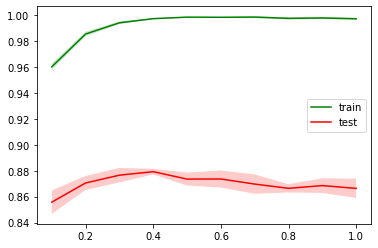

In [51]:
plot_validation_curves(xgb_params['classifier__learning_rate'], xgb_searcher.cv_results_)

In [52]:
xgb_params = {'classifier__n_estimators': [30],
             'classifier__max_depth': [7],
             'classifier__learning_rate': np.linspace(0.1, 1., 10)}

In [53]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

Wall time: 20min 52s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000022BAFF75A60>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000022BAFF75AF0>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      reg_alpha=None,
                                          

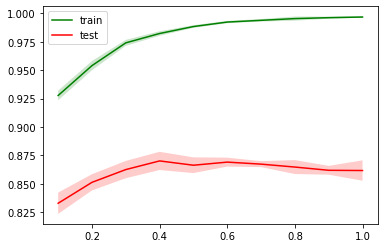

In [54]:
plot_validation_curves(xgb_params['classifier__learning_rate'], xgb_searcher.cv_results_)

In [58]:
xgb_params = {'classifier__n_estimators': np.arange(1, 101, 10),
             'classifier__max_depth': [7],
             'classifier__learning_rate': [0.7]}

In [59]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

Wall time: 25min 33s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000022BAFF75A60>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000022BAFF75AF0>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      random_state=None,
                                       

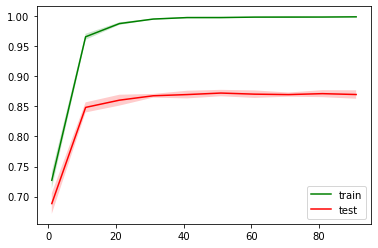

In [60]:
plot_validation_curves(xgb_params['classifier__n_estimators'], xgb_searcher.cv_results_)

In [65]:
xgb_params = {'classifier__n_estimators': [70],
             'classifier__max_depth': [7],
             'classifier__learning_rate': [0.4],
             'classifier__reg_lambda': np.logspace(-4, 4, 10)}

In [66]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

KeyboardInterrupt: 

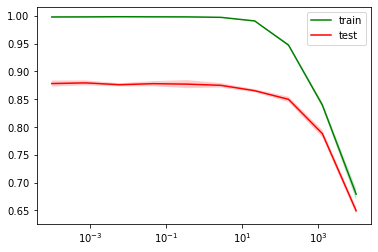

In [64]:
plt.xscale('log')
plot_validation_curves(xgb_params['classifier__reg_lambda'], xgb_searcher.cv_results_)

In [15]:
xgb_params = {'classifier__n_estimators': [70],
             'classifier__max_depth': [7],
             'classifier__learning_rate': [0.4],
             'classifier__reg_alpha': np.logspace(-1, 2, 10)}

In [16]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

Wall time: 33min 34s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000023A4ECB65E0>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000023A4ECB6670>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      tree_method='gpu_hist',
                                  

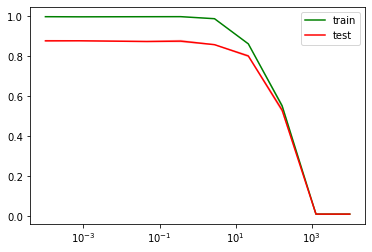

In [70]:
plt.xscale('log')
plot_validation_curves(xgb_params['classifier__reg_alpha'], xgb_searcher.cv_results_)

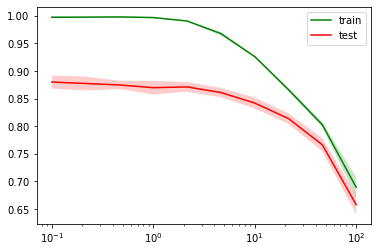

In [17]:
plt.xscale('log')
plot_validation_curves(xgb_params['classifier__reg_alpha'], xgb_searcher.cv_results_)

In [29]:
xgb_params = {'classifier__n_estimators': 70,
             'classifier__max_depth': 7,
             'classifier__learning_rate': 0.4}

In [30]:
pipeline.set_params(**xgb_params)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables',
                                                 FunctionTransformer(func=<function <lambda> at 0x0000023A4ECB65E0>)),
                                                ('categorical_variables',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000023A4ECB6670>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore')),
                                                                 ('dim_reducing',
                                                                  Tru...
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
        

In [32]:
pipeline.fit(X_train, y_train_xgb)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables',
                                                 FunctionTransformer(func=<function <lambda> at 0x0000023A4ECB65E0>)),
                                                ('categorical_variables',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000023A4ECB6670>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore')),
                                                                 ('dim_reducing',
                                                                  Tru...
                               interaction_constraints='', learning_rate=0.4,
                               max_delta_step=0, max_depth=7,


In [33]:
scores_df2 = get_scores_point(pipeline, 'no_l1', *data_params_xgb, multi=True)

In [34]:
scores_df2

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
no_l1,0.898,0.904,0.887,0.994,0.889,0.885


In [35]:
pipeline.set_params(classifier__reg_alpha=1)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables',
                                                 FunctionTransformer(func=<function <lambda> at 0x0000023A4ECB65E0>)),
                                                ('categorical_variables',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000023A4ECB6670>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore')),
                                                                 ('dim_reducing',
                                                                  Tru...
                               interaction_constraints='', learning_rate=0.4,
                               max_delta_step=0, max_depth=7,


In [36]:
pipeline.fit(X_train, y_train_xgb)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables',
                                                 FunctionTransformer(func=<function <lambda> at 0x0000023A4ECB65E0>)),
                                                ('categorical_variables',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000023A4ECB6670>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore')),
                                                                 ('dim_reducing',
                                                                  Tru...
                               interaction_constraints='', learning_rate=0.4,
                               max_delta_step=0, max_depth=7,


In [37]:
scores_df2 = scores_df2.append(get_scores_point(pipeline, 'with_l1', *data_params_xgb, multi=True))

In [45]:
scores_df2

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
no_l1,0.898,0.904,0.887,0.994,0.889,0.885
with_l1,0.888,0.901,0.884,0.994,0.888,0.880


In [21]:
xgb_params = {'classifier__n_estimators': [70],
             'classifier__max_depth': [7],
             'classifier__learning_rate': [0.4],
             'classifier__subsample': np.arange(0.5, 1.01, 0.1)}

In [22]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

Wall time: 27min 55s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x000002D57B71EAF0>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x000002D5014144C0>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      reg_lambda=None,
                                         

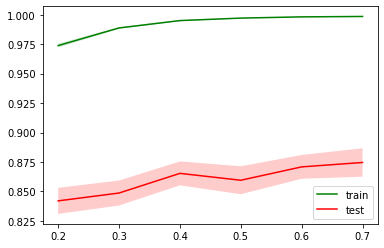

In [20]:
plot_validation_curves(xgb_params['classifier__subsample'], xgb_searcher.cv_results_)

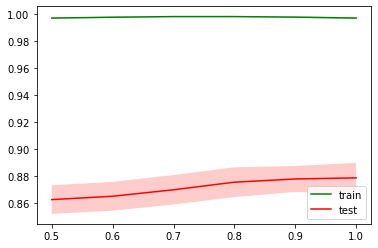

In [23]:
plot_validation_curves(xgb_params['classifier__subsample'], xgb_searcher.cv_results_)

In [24]:
xgb_params = {'classifier__n_estimators': [70],
             'classifier__max_depth': [7],
             'classifier__learning_rate': [0.4],
             'classifier__subsample': [0.8],
             'classifier__colsample_bytree': np.arange(0.3, 1.01, 0.1)}

In [25]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

Wall time: 24min 24s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x000002D57B71EAF0>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x000002D5014144C0>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      subsample=None,
                                          

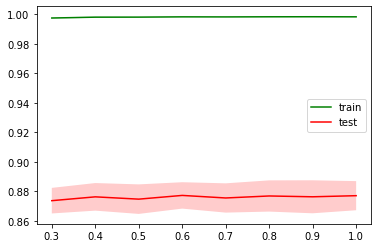

In [26]:
plot_validation_curves(xgb_params['classifier__colsample_bytree'], xgb_searcher.cv_results_)

In [31]:
pipe_params = {'feature_processing__categorical_variables__dim_reducing__n_components': np.arange(5, 46, 5)}

In [32]:
%%time
xgb_searcher = GridSearchCV(pipeline, pipe_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

Wall time: 29min 29s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x000002D57B71EAF0>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x000002D5014144C0>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      predictor='gpu_predictor',
                               

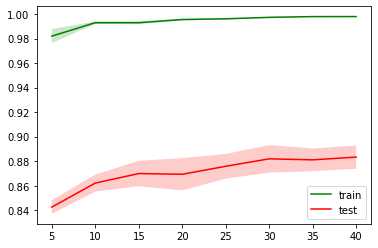

In [34]:
plot_validation_curves(pipe_params['feature_processing__categorical_variables__dim_reducing__n_components'],
                       xgb_searcher.cv_results_)

In [41]:
pipe_params = {'feature_processing__is_top_site__dim_reducing__n_components': np.arange(3, 31, 3)}

In [42]:
%%time
xgb_searcher = GridSearchCV(pipeline, pipe_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

Wall time: 37min 30s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x000002D57B71EAF0>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x000002D5014144C0>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      predictor='gpu_predictor',
                               

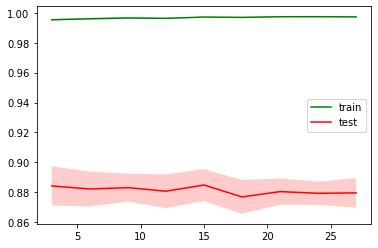

In [43]:
plot_validation_curves(pipe_params['feature_processing__is_top_site__dim_reducing__n_components'],
                       xgb_searcher.cv_results_)

In [59]:
%%time
pipeline.fit(X_train, y_train_xgb)

Wall time: 44.5 s


Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000272D83E9700>)),
                                                ('categorical_variables',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000272D83E90D0>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))])),
                                                ('bag_of_sites',...
                               interaction_constraints='', learning_rate=0.4,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                    

In [60]:
scores_df = scores_df.append(get_scores_point(pipeline, 'xgboost', *data_params_xgb, multi=True))

In [61]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
logit,0.839,0.839,0.81,0.982,0.834,0.796
svm,0.841,0.851,0.82,0.967,0.839,0.809
xgboost,0.879,0.894,0.88,0.992,0.887,0.874


## Отбор признаков

Посмотрим, как добавление категорий признаков влияет на score.

In [71]:
scores_df = scores_df.append(get_scores(xgb_searcher, 'xgb', *data_params_xgb, multi=True))

In [72]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
logit,0.909,0.922,0.910,0.994,0.916,0.904
svm,0.907,0.915,0.898,0.980,0.906,0.893
xgb,1.000,1.000,1.000,1.000,1.000,1.000


In [83]:
scores_df.to_csv('scores_df_2.csv')

### 150 Users

In [74]:
train_150users = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_150users_for_catch_me_ready.csv'), 
                            index_col=0)

In [75]:
train_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,is_top26,is_top27,is_top28,is_top29,is_top30,facebook_freq,binned_start_hour,unique_site_1,unique_site_2,facebook_flag
session_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,4,2,1,4,1,2,1290,321,...,False,False,False,False,False,0,"(6.984, 9.286]",0,0,1
2,2,23,1505,1290,321,321,113,73,49,49,...,False,False,False,False,False,0,"(6.984, 9.286]",0,0,1
3,321,205,1,1,1,1,73,0,0,0,...,False,False,False,False,False,0,"(6.984, 9.286]",0,0,1
4,321,2,1,1,1,6998,6998,5491,6998,6998,...,False,False,False,False,False,0,"(6.984, 9.286]",0,0,1
5,1,35,1,1,1,76,1,58,50,58,...,False,False,False,False,False,0,"(6.984, 9.286]",0,0,1


In [76]:
y_150users = train_150users.user_id
X_train, X_valid, y_train, y_valid = train_test_split(train_150users, y_150users, 
                                                      test_size=0.3, stratify=y_150users)
data_params = [X_train, X_valid, y_train, y_valid]

In [77]:
y = pd.concat((y_train, y_valid), axis=0)
y_xgb = LabelEncoder().fit_transform(y)
y_train_xgb = y_xgb[:y_train.shape[0]]
y_valid_xgb = y_xgb[y_train.shape[0]:]

In [78]:
data_params_xgb = [X_train, X_valid, y_train_xgb, y_valid_xgb]

In [ ]:
xgb_params = {'classifier__n_estimators': np.arange(1, 22, 2),
             'classifier__max_depth': [5]}

In [79]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params, scoring='f1_macro', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train_xgb)

Wall time: 3h 26min 34s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000015FD00BB280>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000015FD00BB310>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      predictor='gpu_predictor',
                               

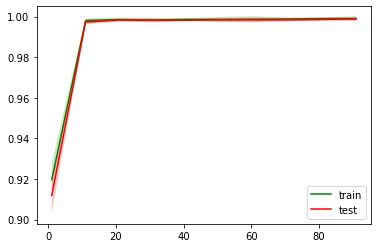

In [80]:
plot_validation_curves(xgb_params['classifier__n_estimators'], xgb_searcher.cv_results_)

In [81]:
scores_df = scores_df.append(get_scores(xgb_searcher, 'xgb_150', *data_params_xgb, multi=True))

In [82]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
logit,0.909,0.922,0.910,0.994,0.916,0.904
svm,0.907,0.915,0.898,0.980,0.906,0.893
xgb,1.000,1.000,1.000,1.000,1.000,1.000
xgb_150,0.999,0.998,0.998,1.000,0.998,0.998


In [84]:
xgb_searcher.best_params_

{'classifier__max_depth': 5, 'classifier__n_estimators': 91}